In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from scipy import signal
# from scipy.io import wavfile

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)

cpu


In [2]:
from IPython.display import Audio, display, clear_output

def play_audio(y, sr, autoplay=False):
    display(Audio(y, rate=sr, autoplay=autoplay))
    
def audio_to_spectrogram(y, sr, normalize=True):
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    if normalize:
        spectrogram = np.interp(spectrogram, (-80., 0.), (-1., +1.))
    return spectrogram
def audios_to_spectrograms(ys, sr, normalize=True):
    spectrograms = []
    for y in ys:
        spectrograms.append(audio_to_spectrogram(y, sr, normalize))
    return np.array(spectrograms)
def spectrogram_to_audio(spectrogram, sr, normalize=True):
    if normalize:
        spectrogram = np.interp(spectrogram, (-1., +1.), (-80., 0.))
    spectrogram = librosa.db_to_power(spectrogram)
    yp = librosa.feature.inverse.mel_to_audio(spectrogram, sr=sr)
    return yp

# def my_audio_to_spectrogram(y, sr):
#     return librosa.stft(y)

# def my_spectrogram_to_audio(spectrogram, sr):
#     return librosa.istft(spectrogram)


def add_spectrograms(*spectrograms, normalize=True):
    result = np.zeros_like(spectrograms[0])
    for spectrogram in spectrograms:
        if normalize:
            spectrogram = np.interp(spectrogram, (-1., +1.), (-80., 0.))
        result += librosa.db_to_power(spectrogram)
    result = librosa.power_to_db(result)
    if normalize:
        result = np.interp(result, (-80., 0.), (-1., +1.))
    return result
# first - second - third, etc.
def subtract_spectrograms(*spectrograms, normalize=True):
    result = spectrograms[0]
    if normalize:
        result = np.interp(result, (-1., +1.), (-80., 0.))
    result = librosa.db_to_power(result)

    for i in range(1, len(spectrograms)):
        spectrogram = spectrograms[i]
        if normalize:
            spectrogram = np.interp(spectrogram, (-1., +1.), (-80., 0.))
        result -= librosa.db_to_power(spectrogram)
    result = librosa.power_to_db(result)
    if normalize:
        result = np.interp(result, (-80., 0.), (-1., +1.))
    return result



def show_audio(y, sr):
    librosa.display.waveplot(y=y, sr=sr)

def show_spectrogram(spectrogram, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', sr=sr, fmax=8000, cmap='gray')
    plt.colorbar(format='%2.2f')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()

In [21]:
y, sr = librosa.load('datasets/samples/bee.wav', sr=None, mono=True, offset=0.0, duration=None)
print('sample rate: ',sr)
print('y.shape', y.shape)

sample rate:  44100
y.shape (1101824,)


In [ ]:
y, sr = librosa.load('/Users/akarshkumar0101/Developer/Class/DSProject/datasets/LibriSpeech/LibriSpeech/dev-clean/2078/142845/2078-142845-0036.flac', sr=None, mono=True, offset=0.0, duration=None)
print('sample rate: ',sr)
print('y.shape', y.shape)

In [ ]:
y, sr = librosa.load(librosa.util.example_audio_file(), sr=None, mono=True, offset=0.0, duration=None)
print('sample rate: ',sr)
print('y.shape', y.shape)

In [ ]:
sr = 10000
full = np.arange(sr*10)
y = np.sin(0.3*full)#*np.sqrt(full))
y2 = np.sin(0.5*full)
del full

# y=y[0:500]
print('sample rate: ',sr)
print('y.shape', y.shape)



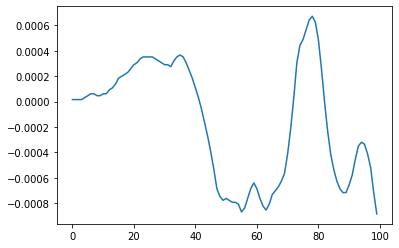

In [26]:
plt.plot(np.arange(100), y[:100])

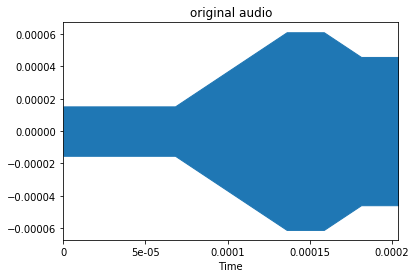

In [24]:
show_audio(y, sr)
plt.title('original audio')
plt.show()

play_audio(y, sr)

In [ ]:
spectrogram = audio_to_spectrogram(y, sr, normalize=True)

show_spectrogram(spectrogram, sr)
plt.show()

In [ ]:
yp = spectrogram_to_audio(spectrogram, sr, normalize=True)
show_audio(yp, sr)
plt.title('reconstructed audio')
plt.show()
play_audio(yp, sr)

In [ ]:
y_noise = 0.3*np.sin(0.2 * np.arange(len(y)))

sy1 = audio_to_spectrogram(y, sr)
sy2 = audio_to_spectrogram(y_noise, sr)
sz = audio_to_spectrogram(y+y_noise, sr)
sz2 = add_spectrograms(sy1, sy2)

sy1re = subtract_spectrograms(sz2, sy2)


#     spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
#     spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
#     if normalize:
#         spectrogram = np.interp(spectrogram, (-80., 0.), (-1., +1.))


# spectrogram = librosa.db_to_power(spectrogram)
#     yp = librosa.feature.inverse.mel_to_audio(spectrogram, sr=sr)

play_audio(y+y_noise, sr)
# play_audio(spectrogram_to_audio(sz, sr), sr)

# play_audio(spectrogram_to_audio(sz2, sr), sr)
play_audio(spectrogram_to_audio(sy1re, sr), sr)




In [3]:
import os
voice_dir = 'datasets/LibriSpeech/LibriSpeech/dev-clean'
noise_dir = 'datasets/urban/UrbanSound8K/audio'

voice_files, noise_files = [], []

for r, d, f in os.walk(voice_dir):
    for file in f:
        if file.endswith('.flac'):
            voice_files.append(os.path.join(r, file))

for r, d, f in os.walk(noise_dir):
    for file in f:
        if file.endswith('.wav'):
            noise_files.append(os.path.join(r, file))


In [4]:
global current_voice_i
global current_noise_i
current_voice_i = 0
current_noise_i = 0

sr = 10000
duration = 4.9
sample_length = int(duration * sr)


def set_sample_length(y, sample_length):
    if len(y) > sample_length:
        y = y[:sample_length]
    if len(y) < sample_length:
        factor = sample_length//len(y)
        oy = y.copy()
        for i in range(factor-1):
            y = np.concatenate((y, oy), axis=0)
        leftover = sample_length - len(y)
        y = np.concatenate((y, oy[:leftover]), axis=0)
    return y

def load_voice_batch(batch_num):
    global current_voice_i
    i = current_voice_i % len(voice_files)
    files = voice_files[i: i+batch_num]
    current_voice_i += batch_num
    
    ys = []
    for file in files:
        y, _ = librosa.load(file, sr=sr, mono=True, offset=0.0, duration=None)
        y = set_sample_length(y, sample_length)
        ys.append(y)
    return np.array(ys)
    
def load_noise_batch(batch_num):
    global current_noise_i
    i = current_noise_i % len(noise_files)
    files = noise_files[i: i+batch_num]
    current_noise_i += batch_num
    
    ys = []
    for file in files:
        y, _ = librosa.load(file, sr=sr, mono=True, offset=0.0, duration=None)
        y = set_sample_length(y, sample_length)
        ys.append(y)
    return np.array(ys)


In [5]:
X_voice_test = load_voice_batch(100)
X_noise_test = load_noise_batch(100)

In [6]:
Y_voice_test = np.ones(X_voice_test.shape[0])
Y_noise_test = np.zeros(X_noise_test.shape[0])

X_test = np.concatenate((X_voice_test, X_noise_test), axis=0)
Y_test = np.concatenate((Y_voice_test, Y_noise_test), axis=0)

X_test = audios_to_spectrograms(X_test, sr)[:, None, :, :]

X_test = torch.from_numpy(X_test).to(device, dtype)
Y_test = torch.from_numpy(Y_test).to(device, dtype)

In [7]:
X_test2 = audios_to_spectrograms(X_voice_test[:1] + X_noise_test[:1], sr)[:, None, :, :]
Y_test2 = audios_to_spectrograms(X_voice_test[:1], sr)[:, None, :, :]

X_test2 = torch.from_numpy(X_test2).to(device, dtype)
Y_test2 = torch.from_numpy(Y_test2).to(device, dtype)

In [ ]:
class VoiceRecogNet(nn.Module):
    def __init__(self):
        super(VoiceRecogNet, self).__init__()
        self.maxpool = nn.MaxPool2d((2,2))
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        self.linear = nn.Linear(12288, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv3(x)
        x = self.maxpool(x)
        x = torch.tanh(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)
        x = torch.relu(x)
        
        x = self.linear2(x)
        x = torch.relu(x)
        
        x = self.linear3(x)
        x = torch.sigmoid(x)
        
        return x
    
vrn = VoiceRecogNet().to(device)

In [ ]:
crit = nn.BCELoss()

Y_test_pred = vrn.forward(X_test)[:, 0]
print('BSE: ', crit(Y_test_pred, Y_test))

Y_test_pred_ = Y_test_pred.detach().cpu().numpy()
Y_test_ = Y_test.detach().cpu().numpy()

accuracy = ((Y_test_pred_>0.5) == (Y_test_>0.5)).sum()/len(Y_test)
print('accuracy: ', accuracy)


del Y_test_pred_
del Y_test_


In [ ]:
crit = nn.BCELoss()
losses = []
batch_num = 5
for epoch in tqdm(range(100)):
    X_voice_batch = load_voice_batch(batch_num)
    X_noise_batch = load_noise_batch(batch_num)
    Y_voice_batch = np.ones(X_voice_batch.shape[0])
    Y_noise_batch = np.zeros(X_noise_batch.shape[0])
    
    X_batch = np.concatenate((X_voice_batch, X_noise_batch), axis=0)
    Y_batch = np.concatenate((Y_voice_batch, Y_noise_batch), axis=0)
    
    X_batch = audios_to_spectrograms(X_batch, sr)[:, None, :, :]
    
    X_batch = torch.from_numpy(X_batch).to(device, dtype)
    Y_batch = torch.from_numpy(Y_batch).to(device, dtype)
    
    
    vrn.opt.zero_grad()
    Y = vrn.forward(X_batch)[:, 0]
    loss = crit(Y, Y_batch)
    
    loss.backward()
    
    vrn.opt.step()
    
    losses.append(loss.detach().cpu().numpy())
    print(loss.detach().cpu().numpy())
    
plt.plot(np.arange(len(losses)), losses)

In [ ]:
crit = nn.BCELoss()

Y_test_pred = vrn.forward(X_test)[:, 0]
print('BSE: ', crit(Y_test_pred, Y_test))

Y_test_pred_ = Y_test_pred.detach().cpu().numpy()
Y_test_ = Y_test.detach().cpu().numpy()

accuracy = ((Y_test_pred_>0.5) == (Y_test_>0.5)).sum()/len(Y_test)
print('accuracy: ', accuracy)


del Y_test_pred_
del Y_test_


In [8]:
class VoiceIsolaterNet(nn.Module):
    def __init__(self):
        super(VoiceIsolaterNet, self).__init__()
        self.maxpool = nn.MaxPool2d((2,2), return_indices=True)
        self.maxunpool = nn.MaxUnpool2d((2,2))
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        
        self.linear1 = nn.Linear(12288, 100)
        self.linear2 = nn.Linear(100, 12288)
        
        self.convt1 = nn.ConvTranspose2d(64, 16, 3, padding=1)
        self.convt2 = nn.ConvTranspose2d(16, 4, 3, padding=1)
        self.convt3 = nn.ConvTranspose2d(4, 1, 3, padding=1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):

        x = self.conv1(x)
        x, ind1 = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv2(x)
        x, ind2 = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv3(x)
        x, ind3 = self.maxpool(x)
        x = torch.tanh(x)
        
        sh = x.shape
        y = x.view(x.shape[0], -1)
        y = self.linear1(y)
        y = torch.relu(y)
        
        y = self.linear2(y)
        y = torch.relu(y)
        
        y = y.view(sh)
        
        
        x = x+y
        x = self.maxunpool(x, ind3)
        x = self.convt1(x)
        x = torch.tanh(x)
        
        x = self.maxunpool(x, ind2)        
        x = self.convt2(x)
        x = torch.tanh(x)
        
        x = self.maxunpool(x, ind1)
        x = self.convt3(x)
        x = torch.tanh(x)
        
        return x
    
vin = VoiceIsolaterNet().to(device)

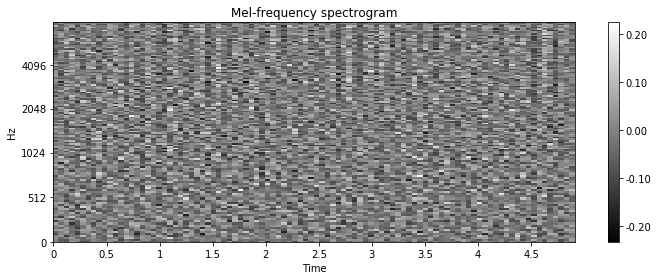

In [9]:
Y_pred = vin.forward(X_test2)[0,0].detach().cpu().numpy()

show_spectrogram(Y_pred, sr)
play_audio(spectrogram_to_audio(Y_pred, sr), sr)

In [19]:
crit = nn.MSELoss()
losses = []

batch_num = 5

for epoch in tqdm(range(500)):
    X_voice_batch = load_voice_batch(batch_num)
    X_noise_batch = load_noise_batch(batch_num)
    
    X_batch = X_voice_batch + X_noise_batch
    X_batch = audios_to_spectrograms(X_batch, sr)[:, None, :, :]
    
    Y_batch = audios_to_spectrograms(X_voice_batch, sr)[:, None, :, :]
    
    X_batch = torch.from_numpy(X_batch).to(device, dtype)
    Y_batch = torch.from_numpy(Y_batch).to(device, dtype)
    
    
    vin.opt.zero_grad()
    Y = vin.forward(X_batch)
    loss = crit(Y, Y_batch)
    
    loss.backward()
    
    vin.opt.step()
    
    losses.append(loss.detach().cpu().numpy())
    print(loss.detach().cpu().numpy())
    
plt.plot(np.arange(len(losses)), losses)


  0%|          | 1/500 [00:02<22:43,  2.73s/it]

0.07712539



  0%|          | 2/500 [00:04<20:11,  2.43s/it]

0.08197549



  1%|          | 3/500 [00:06<19:07,  2.31s/it]

0.10562257



  1%|          | 4/500 [00:08<17:16,  2.09s/it]

0.1754962



  1%|          | 5/500 [00:09<15:06,  1.83s/it]

0.09833839



  1%|          | 6/500 [00:10<14:01,  1.70s/it]

0.11707321



  1%|▏         | 7/500 [00:11<12:48,  1.56s/it]

0.086125016



  2%|▏         | 8/500 [00:13<12:18,  1.50s/it]

0.10904036



  2%|▏         | 9/500 [00:15<13:25,  1.64s/it]

0.10177757



  2%|▏         | 10/500 [00:16<13:09,  1.61s/it]

0.10642029



  2%|▏         | 11/500 [00:18<12:34,  1.54s/it]

0.104496166



  2%|▏         | 12/500 [00:19<12:56,  1.59s/it]

0.088683076



  3%|▎         | 13/500 [00:21<13:35,  1.67s/it]

0.091221236



  3%|▎         | 14/500 [00:23<13:56,  1.72s/it]

0.093607076



  3%|▎         | 15/500 [00:25<14:27,  1.79s/it]

0.099697836



  3%|▎         | 16/500 [00:27<14:05,  1.75s/it]

0.11526404



  3%|▎         | 17/500 [00:28<14:04,  1.75s/it]

0.14059502



  4%|▎         | 18/500 [00:30<14:22,  1.79s/it]

0.11067058



  4%|▍         | 19/500 [00:32<14:09,  1.77s/it]

0.096273564



  4%|▍         | 20/500 [00:34<14:01,  1.75s/it]

0.111506544



  4%|▍         | 21/500 [00:35<13:19,  1.67s/it]

0.118251085



  4%|▍         | 22/500 [00:37<13:30,  1.69s/it]

0.123633035



  5%|▍         | 23/500 [00:39<13:41,  1.72s/it]

0.13435729



  5%|▍         | 24/500 [00:41<13:45,  1.73s/it]

0.16362207



  5%|▌         | 25/500 [00:43<14:22,  1.82s/it]

0.12006011



  5%|▌         | 26/500 [00:44<13:43,  1.74s/it]

0.095200375



  5%|▌         | 27/500 [00:46<14:03,  1.78s/it]

0.104267076



  6%|▌         | 28/500 [00:48<13:50,  1.76s/it]

0.110975645



  6%|▌         | 29/500 [00:49<13:56,  1.78s/it]

0.09852481



  6%|▌         | 30/500 [00:51<14:05,  1.80s/it]

0.12271097



  6%|▌         | 31/500 [00:53<13:34,  1.74s/it]

0.13480856



  6%|▋         | 32/500 [00:55<13:35,  1.74s/it]

0.10671453



  7%|▋         | 33/500 [00:56<13:13,  1.70s/it]

0.11547418



  7%|▋         | 34/500 [00:58<13:30,  1.74s/it]

0.10452244



  7%|▋         | 35/500 [01:00<13:09,  1.70s/it]

0.105457656



  7%|▋         | 36/500 [01:02<13:24,  1.73s/it]

0.11490677



  7%|▋         | 37/500 [01:04<13:54,  1.80s/it]

0.13679408



  8%|▊         | 38/500 [01:06<14:27,  1.88s/it]

0.13429374



  8%|▊         | 39/500 [01:08<16:08,  2.10s/it]

0.10109691



  8%|▊         | 40/500 [01:10<14:54,  1.94s/it]

0.09715576



  8%|▊         | 41/500 [01:12<15:05,  1.97s/it]

0.13040668



  8%|▊         | 42/500 [01:13<14:08,  1.85s/it]

0.11442946



  9%|▊         | 43/500 [01:15<13:06,  1.72s/it]

0.115191065



  9%|▉         | 44/500 [01:16<12:07,  1.60s/it]

0.09423304



  9%|▉         | 45/500 [01:17<11:40,  1.54s/it]

0.10948798



  9%|▉         | 46/500 [01:19<11:40,  1.54s/it]

0.12277423



  9%|▉         | 47/500 [01:20<10:59,  1.46s/it]

0.1275407



 10%|▉         | 48/500 [01:22<10:53,  1.44s/it]

0.14242302



 10%|▉         | 49/500 [01:23<10:29,  1.40s/it]

0.15243737



 10%|█         | 50/500 [01:25<10:59,  1.46s/it]

0.13120383



 10%|█         | 51/500 [01:26<10:53,  1.45s/it]

0.10730388



 10%|█         | 52/500 [01:27<10:39,  1.43s/it]

0.12055978



 11%|█         | 53/500 [01:29<11:06,  1.49s/it]

0.0779311



 11%|█         | 54/500 [01:31<11:03,  1.49s/it]

0.10353483



 11%|█         | 55/500 [01:32<10:48,  1.46s/it]

0.15155801



 11%|█         | 56/500 [01:33<10:35,  1.43s/it]

0.12881272



 11%|█▏        | 57/500 [01:35<11:11,  1.52s/it]

0.10706616



 12%|█▏        | 58/500 [01:36<10:34,  1.44s/it]

0.12778229



 12%|█▏        | 59/500 [01:38<10:44,  1.46s/it]

0.12191753



 12%|█▏        | 60/500 [01:39<10:58,  1.50s/it]

0.112728216



 12%|█▏        | 61/500 [01:41<10:20,  1.41s/it]

0.11932543



 12%|█▏        | 62/500 [01:42<10:45,  1.47s/it]

0.10679822



 13%|█▎        | 63/500 [01:44<10:40,  1.47s/it]

0.10173259



 13%|█▎        | 64/500 [01:45<10:39,  1.47s/it]

0.099659



 13%|█▎        | 65/500 [01:47<11:20,  1.56s/it]

0.10310357



 13%|█▎        | 66/500 [01:49<12:13,  1.69s/it]

0.0845457



 13%|█▎        | 67/500 [01:51<12:35,  1.75s/it]

0.123436384



 14%|█▎        | 68/500 [01:53<12:46,  1.77s/it]

0.12664148



 14%|█▍        | 69/500 [01:55<13:02,  1.81s/it]

0.07258376



 14%|█▍        | 70/500 [01:56<13:18,  1.86s/it]

0.10262804



 14%|█▍        | 71/500 [01:58<13:03,  1.83s/it]

0.123347655



 14%|█▍        | 72/500 [02:00<12:48,  1.80s/it]

0.12209166



 15%|█▍        | 73/500 [02:02<12:20,  1.73s/it]

0.10673427



 15%|█▍        | 74/500 [02:03<12:17,  1.73s/it]

0.088229924



 15%|█▌        | 75/500 [02:05<12:14,  1.73s/it]

0.09382209



 15%|█▌        | 76/500 [02:06<11:27,  1.62s/it]

0.106135145



 15%|█▌        | 77/500 [02:08<11:01,  1.56s/it]

0.12149967



 16%|█▌        | 78/500 [02:09<10:24,  1.48s/it]

0.10813351



 16%|█▌        | 79/500 [02:11<10:42,  1.53s/it]

0.09019207



 16%|█▌        | 80/500 [02:12<11:12,  1.60s/it]

0.08764202



 16%|█▌        | 81/500 [02:14<11:25,  1.64s/it]

0.092194125



 16%|█▋        | 82/500 [02:16<11:11,  1.61s/it]

0.122517556



 17%|█▋        | 83/500 [02:17<10:48,  1.56s/it]

0.08655707



 17%|█▋        | 84/500 [02:19<10:28,  1.51s/it]

0.12823609



 17%|█▋        | 85/500 [02:20<10:19,  1.49s/it]

0.104022816



 17%|█▋        | 86/500 [02:21<09:58,  1.44s/it]

0.11852463



 17%|█▋        | 87/500 [02:23<10:09,  1.48s/it]

0.15948044



 18%|█▊        | 88/500 [02:24<09:30,  1.38s/it]

0.15709655



 18%|█▊        | 89/500 [02:26<10:12,  1.49s/it]

0.10271649



 18%|█▊        | 90/500 [02:27<10:06,  1.48s/it]

0.10795633



 18%|█▊        | 91/500 [02:29<09:56,  1.46s/it]

0.18963283



 18%|█▊        | 92/500 [02:30<09:31,  1.40s/it]

0.15762049



 19%|█▊        | 93/500 [02:32<10:25,  1.54s/it]

0.14793962



 19%|█▉        | 94/500 [02:33<10:28,  1.55s/it]

0.14152238



 19%|█▉        | 95/500 [02:35<10:07,  1.50s/it]

0.09809576



 19%|█▉        | 96/500 [02:36<10:11,  1.51s/it]

0.097367354



 19%|█▉        | 97/500 [02:38<10:32,  1.57s/it]

0.09152337



 20%|█▉        | 98/500 [02:39<10:12,  1.52s/it]

0.12692551



 20%|█▉        | 99/500 [02:41<10:12,  1.53s/it]

0.11870106



 20%|██        | 100/500 [02:42<10:00,  1.50s/it]

0.10571037



 20%|██        | 101/500 [02:44<09:17,  1.40s/it]

0.15539628



 20%|██        | 102/500 [02:45<08:50,  1.33s/it]

0.11621634



 21%|██        | 103/500 [02:46<08:45,  1.32s/it]

0.12704588



 21%|██        | 104/500 [02:48<09:17,  1.41s/it]

0.11054049



 21%|██        | 105/500 [02:49<09:32,  1.45s/it]

0.11558882



 21%|██        | 106/500 [02:51<09:25,  1.43s/it]

0.088806145



 21%|██▏       | 107/500 [02:52<09:24,  1.44s/it]

0.11654532



 22%|██▏       | 108/500 [02:54<09:41,  1.48s/it]

0.09900422



 22%|██▏       | 109/500 [02:55<10:01,  1.54s/it]

0.09466581



 22%|██▏       | 110/500 [02:57<09:40,  1.49s/it]

0.12732746



 22%|██▏       | 111/500 [02:58<09:25,  1.45s/it]

0.11364205



 22%|██▏       | 112/500 [02:59<09:19,  1.44s/it]

0.11495975



 23%|██▎       | 113/500 [03:01<08:35,  1.33s/it]

0.14277358



 23%|██▎       | 114/500 [03:02<08:54,  1.38s/it]

0.100111395



 23%|██▎       | 115/500 [03:03<08:47,  1.37s/it]

0.093576685



 23%|██▎       | 116/500 [03:05<08:53,  1.39s/it]

0.117544025



 23%|██▎       | 117/500 [03:06<08:49,  1.38s/it]

0.10795118



 24%|██▎       | 118/500 [03:07<08:21,  1.31s/it]

0.11838363



 24%|██▍       | 119/500 [03:09<08:37,  1.36s/it]

0.09438537



 24%|██▍       | 120/500 [03:10<08:39,  1.37s/it]

0.10407504



 24%|██▍       | 121/500 [03:12<08:44,  1.38s/it]

0.09655061



 24%|██▍       | 122/500 [03:13<08:36,  1.37s/it]

0.09944615



 25%|██▍       | 123/500 [03:14<08:18,  1.32s/it]

0.14200969



 25%|██▍       | 124/500 [03:16<08:47,  1.40s/it]

0.1279829



 25%|██▌       | 125/500 [03:17<09:10,  1.47s/it]

0.12582184



 25%|██▌       | 126/500 [03:19<08:56,  1.43s/it]

0.15153696



 25%|██▌       | 127/500 [03:20<08:38,  1.39s/it]

0.09585569



 26%|██▌       | 128/500 [03:22<08:55,  1.44s/it]

0.10690587



 26%|██▌       | 129/500 [03:23<08:42,  1.41s/it]

0.08306744



 26%|██▌       | 130/500 [03:24<08:17,  1.34s/it]

0.10112357



 26%|██▌       | 131/500 [03:26<08:44,  1.42s/it]

0.108922824



 26%|██▋       | 132/500 [03:27<08:56,  1.46s/it]

0.10095493



 27%|██▋       | 133/500 [03:29<09:00,  1.47s/it]

0.100006886



 27%|██▋       | 134/500 [03:30<08:28,  1.39s/it]

0.100096814



 27%|██▋       | 135/500 [03:31<08:32,  1.40s/it]

0.080532044



 27%|██▋       | 136/500 [03:33<08:45,  1.44s/it]

0.08541454



 27%|██▋       | 137/500 [03:34<08:46,  1.45s/it]

0.10420524



 28%|██▊       | 138/500 [03:36<08:57,  1.49s/it]

0.092899986



 28%|██▊       | 139/500 [03:37<08:58,  1.49s/it]

0.18010078



 28%|██▊       | 140/500 [03:39<09:12,  1.53s/it]

0.15156421



 28%|██▊       | 141/500 [03:41<09:17,  1.55s/it]

0.17334823



 28%|██▊       | 142/500 [03:42<09:01,  1.51s/it]

0.14181621



 29%|██▊       | 143/500 [03:44<09:06,  1.53s/it]

0.14792703



 29%|██▉       | 144/500 [03:45<09:02,  1.52s/it]

0.11845474



 29%|██▉       | 145/500 [03:47<09:15,  1.56s/it]

0.12761568



 29%|██▉       | 146/500 [03:48<08:54,  1.51s/it]

0.12899838



 29%|██▉       | 147/500 [03:50<09:36,  1.63s/it]

0.12403024



 30%|██▉       | 148/500 [03:52<09:31,  1.62s/it]

0.14297317



 30%|██▉       | 149/500 [03:54<09:58,  1.70s/it]

0.12861985



 30%|███       | 150/500 [03:55<09:29,  1.63s/it]

0.15165679



 30%|███       | 151/500 [03:57<09:24,  1.62s/it]

0.13172677



 30%|███       | 152/500 [03:58<09:15,  1.60s/it]

0.102918915



 31%|███       | 153/500 [04:00<08:59,  1.55s/it]

0.09567717



 31%|███       | 154/500 [04:01<09:13,  1.60s/it]

0.10016088



 31%|███       | 155/500 [04:03<08:53,  1.55s/it]

0.10811117



 31%|███       | 156/500 [04:04<08:56,  1.56s/it]

0.08274896



 31%|███▏      | 157/500 [04:06<08:59,  1.57s/it]

0.084735185



 32%|███▏      | 158/500 [04:07<08:38,  1.52s/it]

0.07906982



 32%|███▏      | 159/500 [04:09<08:31,  1.50s/it]

0.08622193



 32%|███▏      | 160/500 [04:10<08:33,  1.51s/it]

0.074968725



 32%|███▏      | 161/500 [04:12<08:22,  1.48s/it]

0.09959452



 32%|███▏      | 162/500 [04:13<08:16,  1.47s/it]

0.09559654



 33%|███▎      | 163/500 [04:15<08:00,  1.42s/it]

0.09604327



 33%|███▎      | 164/500 [04:16<07:51,  1.40s/it]

0.074517645



 33%|███▎      | 165/500 [04:17<07:52,  1.41s/it]

0.07400623



 33%|███▎      | 166/500 [04:19<07:46,  1.40s/it]

0.06833233



 33%|███▎      | 167/500 [04:20<07:37,  1.37s/it]

0.080662884



 34%|███▎      | 168/500 [04:21<07:26,  1.34s/it]

0.07363935



 34%|███▍      | 169/500 [04:23<08:02,  1.46s/it]

0.0927206



 34%|███▍      | 170/500 [04:25<08:07,  1.48s/it]

0.06605662



 34%|███▍      | 171/500 [04:26<07:43,  1.41s/it]

0.13120267



 34%|███▍      | 172/500 [04:27<07:17,  1.33s/it]

0.08418408



 35%|███▍      | 173/500 [04:29<07:56,  1.46s/it]

0.07856236



 35%|███▍      | 174/500 [04:30<08:08,  1.50s/it]

0.08012041



 35%|███▌      | 175/500 [04:32<07:58,  1.47s/it]

0.08335297



 35%|███▌      | 176/500 [04:33<07:46,  1.44s/it]

0.08405967



 35%|███▌      | 177/500 [04:34<07:37,  1.42s/it]

0.09351247



 36%|███▌      | 178/500 [04:36<07:19,  1.36s/it]

0.069797285



 36%|███▌      | 179/500 [04:37<06:59,  1.31s/it]

0.07988493



 36%|███▌      | 180/500 [04:38<06:41,  1.25s/it]

0.08447597



 36%|███▌      | 181/500 [04:39<06:53,  1.30s/it]

0.06995142



 36%|███▋      | 182/500 [04:41<06:38,  1.25s/it]

0.07599988



 37%|███▋      | 183/500 [04:42<06:43,  1.27s/it]

0.07348456



 37%|███▋      | 184/500 [04:43<06:26,  1.22s/it]

0.11040424



 37%|███▋      | 185/500 [04:44<06:34,  1.25s/it]

0.12414317



 37%|███▋      | 186/500 [04:46<06:53,  1.32s/it]

0.13167945



 37%|███▋      | 187/500 [04:47<07:16,  1.39s/it]

0.10442635



 38%|███▊      | 188/500 [04:49<07:01,  1.35s/it]

0.10319789



 38%|███▊      | 189/500 [04:50<06:45,  1.30s/it]

0.12585062



 38%|███▊      | 190/500 [04:51<06:34,  1.27s/it]

0.1310365



 38%|███▊      | 191/500 [04:52<06:30,  1.26s/it]

0.13839373



 38%|███▊      | 192/500 [04:54<07:07,  1.39s/it]

0.094096094



 39%|███▊      | 193/500 [04:55<07:05,  1.39s/it]

0.12539546



 39%|███▉      | 194/500 [04:57<07:17,  1.43s/it]

0.10153354



 39%|███▉      | 195/500 [04:58<07:15,  1.43s/it]

0.09961664



 39%|███▉      | 196/500 [04:59<06:59,  1.38s/it]

0.09356806



 39%|███▉      | 197/500 [05:01<07:10,  1.42s/it]

0.10503901



 40%|███▉      | 198/500 [05:02<07:06,  1.41s/it]

0.12665842



 40%|███▉      | 199/500 [05:04<06:50,  1.36s/it]

0.13247791



 40%|████      | 200/500 [05:05<06:55,  1.39s/it]

0.06778543



 40%|████      | 201/500 [05:06<06:41,  1.34s/it]

0.100042515



 40%|████      | 202/500 [05:08<06:30,  1.31s/it]

0.09064422



 41%|████      | 203/500 [05:09<06:24,  1.29s/it]

0.10584246



 41%|████      | 204/500 [05:10<06:24,  1.30s/it]

0.097798735



 41%|████      | 205/500 [05:11<06:17,  1.28s/it]

0.10608484



 41%|████      | 206/500 [05:13<06:36,  1.35s/it]

0.0852824



 41%|████▏     | 207/500 [05:14<06:18,  1.29s/it]

0.10768277



 42%|████▏     | 208/500 [05:15<06:27,  1.33s/it]

0.09084709



 42%|████▏     | 209/500 [05:17<06:35,  1.36s/it]

0.067383535



 42%|████▏     | 210/500 [05:18<06:29,  1.34s/it]

0.10520555



 42%|████▏     | 211/500 [05:20<06:37,  1.37s/it]

0.08133174



 42%|████▏     | 212/500 [05:21<06:55,  1.44s/it]

0.080788486



 43%|████▎     | 213/500 [05:23<07:16,  1.52s/it]

0.07801296



 43%|████▎     | 214/500 [05:25<07:53,  1.66s/it]

0.068493724



 43%|████▎     | 215/500 [05:27<09:04,  1.91s/it]

0.08179446



 43%|████▎     | 216/500 [05:30<09:32,  2.02s/it]

0.05367376



 43%|████▎     | 217/500 [05:32<09:17,  1.97s/it]

0.094025925



 44%|████▎     | 218/500 [05:33<09:13,  1.96s/it]

0.059188884



 44%|████▍     | 219/500 [05:35<08:44,  1.87s/it]

0.08045101



 44%|████▍     | 220/500 [05:37<08:18,  1.78s/it]

0.07399011



 44%|████▍     | 221/500 [05:38<07:25,  1.60s/it]

0.06906533



 44%|████▍     | 222/500 [05:40<08:07,  1.75s/it]

0.0721917



 45%|████▍     | 223/500 [05:41<07:43,  1.67s/it]

0.10824533



 45%|████▍     | 224/500 [05:43<07:44,  1.68s/it]

0.13888736



 45%|████▌     | 225/500 [05:44<07:05,  1.55s/it]

0.12444405



 45%|████▌     | 226/500 [05:46<06:47,  1.49s/it]

0.11516647



 45%|████▌     | 227/500 [05:47<06:44,  1.48s/it]

0.106087014



 46%|████▌     | 228/500 [05:48<06:23,  1.41s/it]

0.08950222



 46%|████▌     | 229/500 [05:50<06:22,  1.41s/it]

0.08959059



 46%|████▌     | 230/500 [05:52<06:40,  1.48s/it]

0.12956944



 46%|████▌     | 231/500 [05:53<06:46,  1.51s/it]

0.11667815



 46%|████▋     | 232/500 [05:54<06:29,  1.45s/it]

0.09062625



 47%|████▋     | 233/500 [05:56<06:23,  1.44s/it]

0.106151246



 47%|████▋     | 234/500 [05:57<06:16,  1.42s/it]

0.13428588



 47%|████▋     | 235/500 [05:59<06:21,  1.44s/it]

0.12598923



 47%|████▋     | 236/500 [06:00<06:04,  1.38s/it]

0.11714562



 47%|████▋     | 237/500 [06:01<06:00,  1.37s/it]

0.11458211



 48%|████▊     | 238/500 [06:02<05:35,  1.28s/it]

0.135355



 48%|████▊     | 239/500 [06:04<05:44,  1.32s/it]

0.14182396



 48%|████▊     | 240/500 [06:05<06:00,  1.39s/it]

0.11637868



 48%|████▊     | 241/500 [06:07<06:24,  1.48s/it]

0.11301895



 48%|████▊     | 242/500 [06:09<06:25,  1.50s/it]

0.09122208



 49%|████▊     | 243/500 [06:10<06:05,  1.42s/it]

0.0894591



 49%|████▉     | 244/500 [06:11<06:02,  1.42s/it]

0.061717223



 49%|████▉     | 245/500 [06:12<05:45,  1.36s/it]

0.07935982



 49%|████▉     | 246/500 [06:14<05:53,  1.39s/it]

0.07651961



 49%|████▉     | 247/500 [06:15<05:26,  1.29s/it]

0.09043126



 50%|████▉     | 248/500 [06:16<05:41,  1.36s/it]

0.071367376



 50%|████▉     | 249/500 [06:18<05:25,  1.30s/it]

0.07676074



 50%|█████     | 250/500 [06:19<05:30,  1.32s/it]

0.07770245



 50%|█████     | 251/500 [06:21<05:44,  1.38s/it]

0.078213975



 50%|█████     | 252/500 [06:22<05:53,  1.43s/it]

0.06939504



 51%|█████     | 253/500 [06:23<05:53,  1.43s/it]

0.06687595



 51%|█████     | 254/500 [06:25<06:12,  1.51s/it]

0.063160226



 51%|█████     | 255/500 [06:27<06:02,  1.48s/it]

0.082323



 51%|█████     | 256/500 [06:28<06:13,  1.53s/it]

0.11376182



 51%|█████▏    | 257/500 [06:30<06:10,  1.53s/it]

0.10283588



 52%|█████▏    | 258/500 [06:31<06:11,  1.53s/it]

0.09759749



 52%|█████▏    | 259/500 [06:33<06:06,  1.52s/it]

0.11614712



 52%|█████▏    | 260/500 [06:34<05:55,  1.48s/it]

0.17104954



 52%|█████▏    | 261/500 [06:36<05:52,  1.47s/it]

0.16361125



 52%|█████▏    | 262/500 [06:37<05:55,  1.49s/it]

0.13139683



 53%|█████▎    | 263/500 [06:39<06:01,  1.53s/it]

0.13016035



 53%|█████▎    | 264/500 [06:40<05:52,  1.49s/it]

0.11816985



 53%|█████▎    | 265/500 [06:42<05:45,  1.47s/it]

0.1138776



 53%|█████▎    | 266/500 [06:43<05:41,  1.46s/it]

0.11098504



 53%|█████▎    | 267/500 [06:44<05:29,  1.41s/it]

0.12366986



 54%|█████▎    | 268/500 [06:46<05:22,  1.39s/it]

0.122921616



 54%|█████▍    | 269/500 [06:47<05:15,  1.36s/it]

0.11255331



 54%|█████▍    | 270/500 [06:48<05:15,  1.37s/it]

0.1116539



 54%|█████▍    | 271/500 [06:50<05:15,  1.38s/it]

0.21551962



 54%|█████▍    | 272/500 [06:51<05:19,  1.40s/it]

0.15768579



 55%|█████▍    | 273/500 [06:53<05:18,  1.40s/it]

0.10941839



 55%|█████▍    | 274/500 [06:54<05:23,  1.43s/it]

0.08767555



 55%|█████▌    | 275/500 [06:56<05:30,  1.47s/it]

0.09260574



 55%|█████▌    | 276/500 [06:57<05:21,  1.43s/it]

0.08154239



 55%|█████▌    | 277/500 [06:59<05:25,  1.46s/it]

0.08014917



 56%|█████▌    | 278/500 [07:00<05:21,  1.45s/it]

0.1685917



 56%|█████▌    | 279/500 [07:01<05:23,  1.46s/it]

0.10405509



 56%|█████▌    | 280/500 [07:03<05:22,  1.47s/it]

0.104883514



 56%|█████▌    | 281/500 [07:04<05:14,  1.44s/it]

0.09903654



 56%|█████▋    | 282/500 [07:06<05:17,  1.45s/it]

0.11675836



 57%|█████▋    | 283/500 [07:07<04:59,  1.38s/it]

0.11435611



 57%|█████▋    | 284/500 [07:08<05:01,  1.40s/it]

0.098492414



 57%|█████▋    | 285/500 [07:10<05:25,  1.51s/it]

0.075503595



 57%|█████▋    | 286/500 [07:12<05:38,  1.58s/it]

0.07148945



 57%|█████▋    | 287/500 [07:13<05:15,  1.48s/it]

0.06434793



 58%|█████▊    | 288/500 [07:15<05:18,  1.50s/it]

0.049672566



 58%|█████▊    | 289/500 [07:16<05:22,  1.53s/it]

0.07411378



 58%|█████▊    | 290/500 [07:18<05:25,  1.55s/it]

0.08170338



 58%|█████▊    | 291/500 [07:20<05:29,  1.58s/it]

0.07786012



 58%|█████▊    | 292/500 [07:21<05:39,  1.63s/it]

0.061454955



 59%|█████▊    | 293/500 [07:23<05:24,  1.57s/it]

0.08591369



 59%|█████▉    | 294/500 [07:25<05:37,  1.64s/it]

0.04898908



 59%|█████▉    | 295/500 [07:26<05:26,  1.59s/it]

0.063791685



 59%|█████▉    | 296/500 [07:28<05:28,  1.61s/it]

0.10165145



 59%|█████▉    | 297/500 [07:29<05:12,  1.54s/it]

0.15260378



 60%|█████▉    | 298/500 [07:31<05:02,  1.50s/it]

0.081019305



 60%|█████▉    | 299/500 [07:32<04:50,  1.44s/it]

0.121570356



 60%|██████    | 300/500 [07:34<05:05,  1.53s/it]

0.11729963



 60%|██████    | 301/500 [07:35<04:47,  1.45s/it]

0.10583808



 60%|██████    | 302/500 [07:36<04:46,  1.45s/it]

0.1042644



 61%|██████    | 303/500 [07:38<05:12,  1.59s/it]

0.103892714



 61%|██████    | 304/500 [07:40<05:14,  1.61s/it]

0.12696524



 61%|██████    | 305/500 [07:41<05:10,  1.59s/it]

0.076040365



 61%|██████    | 306/500 [07:43<05:27,  1.69s/it]

0.07022128



 61%|██████▏   | 307/500 [07:45<05:08,  1.60s/it]

0.07920699



 62%|██████▏   | 308/500 [07:47<05:39,  1.77s/it]

0.11063196



 62%|██████▏   | 309/500 [07:48<05:18,  1.67s/it]

0.07804019



 62%|██████▏   | 310/500 [07:50<05:14,  1.65s/it]

0.0979291



 62%|██████▏   | 311/500 [07:52<05:11,  1.65s/it]

0.09183955



 62%|██████▏   | 312/500 [07:53<05:23,  1.72s/it]

0.10386541



 63%|██████▎   | 313/500 [07:55<05:10,  1.66s/it]

0.12599388



 63%|██████▎   | 314/500 [07:56<05:01,  1.62s/it]

0.10520525



 63%|██████▎   | 315/500 [07:58<04:56,  1.60s/it]

0.10692293



 63%|██████▎   | 316/500 [08:00<04:59,  1.63s/it]

0.09582284



 63%|██████▎   | 317/500 [08:01<04:47,  1.57s/it]

0.07095759



 64%|██████▎   | 318/500 [08:03<04:53,  1.61s/it]

0.08789653



 64%|██████▍   | 319/500 [08:05<05:04,  1.68s/it]

0.1012547



 64%|██████▍   | 320/500 [08:06<05:06,  1.71s/it]

0.06628232



 64%|██████▍   | 321/500 [08:08<05:04,  1.70s/it]

0.08437668



 64%|██████▍   | 322/500 [08:10<04:55,  1.66s/it]

0.091193534



 65%|██████▍   | 323/500 [08:11<04:44,  1.61s/it]

0.10871296



 65%|██████▍   | 324/500 [08:13<04:31,  1.54s/it]

0.080696106



 65%|██████▌   | 325/500 [08:14<04:42,  1.61s/it]

0.09746447



 65%|██████▌   | 326/500 [08:16<04:44,  1.64s/it]

0.09310403



 65%|██████▌   | 327/500 [08:18<05:14,  1.82s/it]

0.07614778



 66%|██████▌   | 328/500 [08:20<05:10,  1.80s/it]

0.08176534



 66%|██████▌   | 329/500 [08:21<04:37,  1.62s/it]

0.09563361



 66%|██████▌   | 330/500 [08:23<04:23,  1.55s/it]

0.10010766



 66%|██████▌   | 331/500 [08:24<04:14,  1.50s/it]

0.09382248



 66%|██████▋   | 332/500 [08:25<04:06,  1.46s/it]

0.080525704



 67%|██████▋   | 333/500 [08:27<03:56,  1.42s/it]

0.083188176



 67%|██████▋   | 334/500 [08:28<04:02,  1.46s/it]

0.08695



 67%|██████▋   | 335/500 [08:30<03:48,  1.39s/it]

0.09025284



 67%|██████▋   | 336/500 [08:31<03:59,  1.46s/it]

0.102982305



 67%|██████▋   | 337/500 [08:33<04:15,  1.57s/it]

0.0727878



 68%|██████▊   | 338/500 [08:35<04:21,  1.61s/it]

0.07433616



 68%|██████▊   | 339/500 [08:36<04:05,  1.52s/it]

0.07707713



 68%|██████▊   | 340/500 [08:37<03:59,  1.49s/it]

0.06265352



 68%|██████▊   | 341/500 [08:39<03:51,  1.45s/it]

0.08061257



 68%|██████▊   | 342/500 [08:40<03:46,  1.43s/it]

0.06329684



 69%|██████▊   | 343/500 [08:41<03:38,  1.39s/it]

0.08402084



 69%|██████▉   | 344/500 [08:43<03:21,  1.29s/it]

0.12197809



 69%|██████▉   | 345/500 [08:44<03:27,  1.34s/it]

0.06217679



 69%|██████▉   | 346/500 [08:45<03:26,  1.34s/it]

0.068635665



 69%|██████▉   | 347/500 [08:47<03:25,  1.34s/it]

0.06881845



 70%|██████▉   | 348/500 [08:48<03:24,  1.34s/it]

0.09559417



 70%|██████▉   | 349/500 [08:50<03:52,  1.54s/it]

0.073916905



 70%|███████   | 350/500 [08:52<04:10,  1.67s/it]

0.07998005



 70%|███████   | 351/500 [08:53<04:00,  1.62s/it]

0.08976663



 70%|███████   | 352/500 [08:55<03:54,  1.58s/it]

0.08040439



 71%|███████   | 353/500 [08:57<04:07,  1.68s/it]

0.06771537



 71%|███████   | 354/500 [08:58<03:53,  1.60s/it]

0.07597205



 71%|███████   | 355/500 [09:00<03:46,  1.56s/it]

0.0743837



 71%|███████   | 356/500 [09:01<03:41,  1.54s/it]

0.06357067



 71%|███████▏  | 357/500 [09:03<03:50,  1.61s/it]

0.059313968



 72%|███████▏  | 358/500 [09:05<03:49,  1.62s/it]

0.06588169



 72%|███████▏  | 359/500 [09:06<03:56,  1.68s/it]

0.064688854



 72%|███████▏  | 360/500 [09:09<04:14,  1.82s/it]

0.06993858



 72%|███████▏  | 361/500 [09:11<04:14,  1.83s/it]

0.07711356



 72%|███████▏  | 362/500 [09:12<04:06,  1.79s/it]

0.058975734



 73%|███████▎  | 363/500 [09:14<03:55,  1.72s/it]

0.06947661



 73%|███████▎  | 364/500 [09:16<04:03,  1.79s/it]

0.068387695



 73%|███████▎  | 365/500 [09:17<03:50,  1.71s/it]

0.07113871



 73%|███████▎  | 366/500 [09:19<03:41,  1.65s/it]

0.075441465



 73%|███████▎  | 367/500 [09:21<03:44,  1.69s/it]

0.052047126



 74%|███████▎  | 368/500 [09:22<03:48,  1.73s/it]

0.06529285



 74%|███████▍  | 369/500 [09:24<04:02,  1.85s/it]

0.056940667



 74%|███████▍  | 370/500 [09:26<03:49,  1.77s/it]

0.07497941



 74%|███████▍  | 371/500 [09:28<04:00,  1.87s/it]

0.065880656



 74%|███████▍  | 372/500 [09:30<04:04,  1.91s/it]

0.06296463



 75%|███████▍  | 373/500 [09:32<03:43,  1.76s/it]

0.07506911



 75%|███████▍  | 374/500 [09:33<03:25,  1.63s/it]

0.080962814



 75%|███████▌  | 375/500 [09:34<03:19,  1.59s/it]

0.07131349



 75%|███████▌  | 376/500 [09:36<03:02,  1.47s/it]

0.07162372



 75%|███████▌  | 377/500 [09:37<02:50,  1.39s/it]

0.06869971



 76%|███████▌  | 378/500 [09:38<02:37,  1.29s/it]

0.08643358



 76%|███████▌  | 379/500 [09:39<02:40,  1.33s/it]

0.07472441



 76%|███████▌  | 380/500 [09:41<02:40,  1.34s/it]

0.056513153



 76%|███████▌  | 381/500 [09:42<02:33,  1.29s/it]

0.080745205



 76%|███████▋  | 382/500 [09:43<02:31,  1.29s/it]

0.06831119



 77%|███████▋  | 383/500 [09:44<02:32,  1.30s/it]

0.09640615



 77%|███████▋  | 384/500 [09:46<02:31,  1.31s/it]

0.07256133



 77%|███████▋  | 385/500 [09:48<02:55,  1.52s/it]

0.060105305



 77%|███████▋  | 386/500 [09:49<02:53,  1.52s/it]

0.0731437



 77%|███████▋  | 387/500 [09:51<02:57,  1.57s/it]

0.06803204


ValueError: operands could not be broadcast together with shapes (3,49000) (5,49000) 

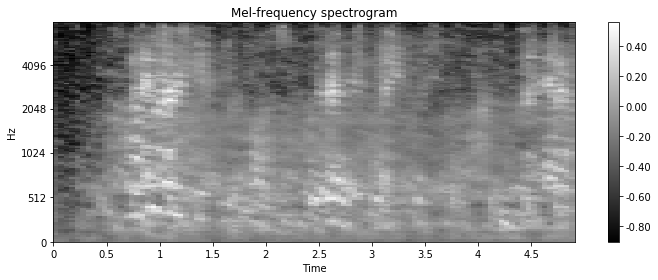

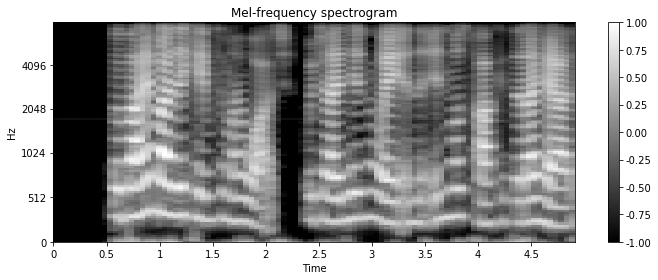

In [20]:
Y_pred = vin.forward(X_test2)[0,0].detach().cpu().numpy()

show_spectrogram(Y_pred, sr)
plt.show()
show_spectrogram(Y_test2[0,0].detach().cpu().numpy(), sr)
plt.show()
play_audio(spectrogram_to_audio(Y_pred, sr), sr)
play_audio(spectrogram_to_audio(Y_test2[0,0], sr), sr)

In [ ]:
class TempNet(nn.Module):
    def __init__(self):
        super(TempNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, padding=1)
        self.conv2 = nn.Conv2d(2, 4, 3, padding=1)
        self.conv3 = nn.Conv2d(4, 8, 3, padding=1)
        
        self.convt1 = nn.ConvTranspose2d(8, 4, 3, padding=1)
        self.convt2 = nn.ConvTranspose2d(4, 2, 3, padding=1)
        self.convt3 = nn.ConvTranspose2d(2, 1, 3, padding=1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)
        x = torch.tanh(x)
        
        return x
    
tn = TempNet().to(device)

In [ ]:
X = torch.from_numpy(spectrogram)[None, None, ...].float()

In [ ]:
spectrogramp = tn.forward(X).detach().cpu().numpy()[0,0]
show_spectrogram(spectrogramp, sr)
plt.show()
play_audio(spectrogram_to_audio(spectrogramp, sr, normalize=True), sr)

In [ ]:
crit = nn.MSELoss()
losses = []
for epoch in tqdm(range(500)):
    Y = tn.forward(X)
    loss = crit(X, Y)
    
    loss.backward()
    
    tn.opt.step()
    tn.opt.zero_grad()
    
    losses.append(loss.detach().cpu().numpy())
    
plt.plot(np.arange(len(losses)), losses)

In [ ]:
spectrogramp = tn.forward(X).detach().cpu().numpy()[0,0]
show_spectrogram(spectrogramp, sr)
play_audio(spectrogram_to_audio(spectrogramp, sr, normalize=True), sr)

# Idea for the future:


so we make a audio classifer. Train it heavily with lots of data and use Conv1d

D: raw audio -> is human speech or not


Then we train network to take mixed audio signal and seperate it into speech and noise

we make sure speech is speech with D. we can make sure noise is noise with ~D. the sum should be the signal


compare these results with the simple noisy -> speech model
